In [1]:
import os
import mne
import pycartool.io
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib qt

import umap
from features import *
from my_io import *

D:\Python\envs\epilespy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read EEG data

In [30]:
def read_epiliptic_events(file, sfreq):
    df = pd.read_csv(file, sep="\t", skiprows=1, names=['start', 'stop', 'label'])
    df['start_time'] = df['start'] / sfreq
    df['stop_time'] = df['stop'] / sfreq
    df['duration'] = df['stop_time'] - df['start_time']
    df['label'] = [l.split('_')[0] for l in df['label'].values]
    annotations = mne.Annotations(df['start_time'], df['duration'], df['label'])
    return(annotations)
file = fr'V:\switchdrive\Brainhack\KMR11\d17\Epileptic_events.mrk'

def read_file(fname):
    # Read Raw
    base_path = os.path.dirname(fname) 
    base_name = os.path.basename(fname)
    raw = pycartool.io.read_sef(fname)
    # Read Bads
    bad_annotations = mne.Annotations(0, 0, 'null')
    for file in os.listdir(base_path):
        if file.lower().startswith('bad'):
            print(file)
            path = os.path.join(base_path, file)
            annotations = read_bad_file(path, raw.info['sfreq'])
            bad_annotations += annotations
    # Read epileptic
    epileptic_annotations = mne.Annotations(0, 0, 'null')
    for file in os.listdir(base_path):
        if file.lower().startswith('epileptic'):
            print(file)
            path = os.path.join(base_path, file)
            annotations = read_epiliptic_events(path, raw.info['sfreq'])
            epileptic_annotations += annotations
    # Read background
    background_annotations = mne.Annotations(0, 0, 'null')
    for file in os.listdir(base_path):
        if file.lower().endswith('bck.mrk'):
            print(file)
            path = os.path.join(base_path, file)
            annotations = read_background_events_file(path, raw.info['sfreq'])
            background_annotations += annotations
    annotations = epileptic_annotations + bad_annotations + background_annotations
    raw.set_annotations(annotations) 
    return(raw)

In [31]:
files = list()

subject_folder = fr'V:\switchdrive\Brainhack\KMR11'
for day_folder in os.listdir(subject_folder):
    day_folder = os.path.join(subject_folder, day_folder)
    if os.path.isdir(day_folder):
        for file in os.listdir(day_folder):
            if file.endswith('.sef'):
                file = os.path.join(day_folder, file)
                files.append(file)

In [32]:
all_features = []
for file in files:
    try:
        day = file.split("\\")[4]
        subject = file.split("\\")[3]
        features = []
        raw = read_file(file)
        raw.pick(['e11'])
        raw.filter(1., None)
        events, events_id = mne.events_from_annotations(raw, chunk_duration=1)
        epochs = mne.Epochs(raw, events, event_id=events_id, tmin=0, tmax=1, baseline=None, on_missing='ignore')
        data = epochs.get_data()

        activity_features = activity(data)
        features.append(activity_features)

        mobility_features = mobility(data)
        features.append(mobility_features)

        complexity_features = complexity(data)
        features.append(complexity_features)

        time_features = extract_time_feat(data)
        features.append(time_features.reshape((time_features.shape[0],-1)))

        frequency_features = extract_freq_feat(data, sfreq=epochs.info['sfreq'])
        features.append(frequency_features.reshape((frequency_features.shape[0],-1)))

        information_features = extract_information_feat(data, sfreq=epochs.info['sfreq'])
        features.append(information_features.reshape((information_features.shape[0],-1)))

        dwt_features = extract_dwt_feat(data)
        features.append(dwt_features.reshape((dwt_features.shape[0],-1)))

        events = epochs.events[:,2].reshape(-1,1)
        features.append(events)

        days = np.array([day] * len(epochs)).reshape(-1,1)
        features.append(days)

        subjects = np.array([subject] * len(epochs)).reshape(-1,1)
        features.append(subjects)

        features = np.hstack(features)
        all_features.append(features)
    except Exception as e:
        print(file , e)


df = pd.DataFrame(np.vstack(all_features))

[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15724608
    Range : 0 ... 15724607 =      0.000 ...  3931.152 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Used Annotations descriptions: ['FR', 'RP', 'background', 'null']
Not setting metadata
203 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 203 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15708224
    Range : 0 ... 15708223 =      0.000 ...  3927.056 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
Not setting metadata
141 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 141 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15297920
    Range : 0 ... 15297919 =      0.000 ...  3824.480 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Used Annotations descriptions: ['FR', 'RP', 'background', 'null']
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14941504
    Range : 0 ... 14941503 =      0.000 ...  3735.376 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


Used Annotations descriptions: ['FR', 'RP', 'background', 'null']
Not setting metadata
234 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 234 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14403904
    Range : 0 ... 14403903 =      0.000 ...  3600.976 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


Used Annotations descriptions: ['HALF', 'LALF', 'background', 'null']
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 136 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=19329472
    Range : 0 ... 19329471 =      0.000 ...  4832.368 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
Not setting metadata
175 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 175 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=19748352
    Range : 0 ... 19748351 =      0.000 ...  4937.088 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
Not setting metadata
207 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 207 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14959040
    Range : 0 ... 14959039 =      0.000 ...  3739.760 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Used Annotations descriptions: ['HALF', 'background', 'null']
Not setting metadata
197 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 197 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15884096
    Range : 0 ... 15884095 =      0.000 ...  3971.024 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 138 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=19878144
    Range : 0 ... 19878143 =      0.000 ...  4969.536 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


Used Annotations descriptions: ['HAHF', 'HALF', 'LALF', 'background', 'null']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14439424
    Range : 0 ... 14439423 =      0.000 ...  3609.856 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Used Annotations descriptions: ['LAHF', 'LALF', 'background', 'null']
Not setting metadata
177 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 177 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=12575296
    Range : 0 ... 12575295 =      0.000 ...  3143.824 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Used Annotations descriptions: ['background', 'null']
Not setting metadata
184 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 184 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14598144
    Range : 0 ... 14598143 =      0.000 ...  3649.536 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Used Annotations descriptions: ['background', 'null']
Not setting metadata
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15534976
    Range : 0 ... 15534975 =      0.000 ...  3883.744 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Used Annotations descriptions: ['FR', 'RP', 'background', 'null']
Not setting metadata
197 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 197 events and 4001 original time points ...
0 bad epochs dropped


In [33]:
df = pd.DataFrame(np.vstack(all_features))
df.add_prefix('col_')

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49
0,2453.4060098848254,0.1466081776681534,5.507685012300277,-15.893888083094156,2453.4060098848254,-0.00364107091749015,-0.059393515823235266,-0.008399063643633582,52.733405142575016,-0.07739196965265174,...,1.5797212161657654,0.2817590438618665,-0.43124652991330137,271.4804143447874,0.007871438644986116,0.3825108407989477,0.31560406132848523,3,d11,KMR11
1,3151.1463722163726,0.09984682934051546,8.13166912292502,26.70827599286666,3151.1463722163726,-0.1606928790833398,-0.7115438113191952,-0.016608796092443975,31.41500501840653,-0.056205036817194104,...,0.9050265936626998,0.26773969163360334,-0.31050897098647506,149.87613315679968,-0.5014955265854796,5.563045239512972,0.2834721475206618,3,d11,KMR11
2,5662.239500975381,0.07221656865868804,11.127719323495242,22.694292822922897,5662.239500975381,-0.10642803273992579,-0.6816240190195799,0.035268521803472466,29.529897103723552,-0.028893544838305373,...,-0.4504417134128649,0.2631583857050202,-0.2228375333738291,193.6218353745105,-0.5866299532472117,14.14578903226717,0.30233594740511344,3,d11,KMR11
3,2918.87731059371,0.13339157283906827,6.309124262257655,20.108847317531342,2918.87731059371,-0.5509732718361681,-0.3222166287953212,0.03615854660554168,51.93649381452949,-0.06756969344501806,...,0.3398690960968489,0.2981316127408721,-1.1707185222803183,281.0213552000958,-0.25694332310659995,14.188009800487542,0.2861970497696065,3,d11,KMR11
4,1829.4091518648133,0.16596957271246982,4.8001037258324315,21.967559224259762,1829.4091518648133,-0.44816995342410143,0.034527434115248834,0.01293894981824117,50.39271984834305,-0.273769210125848,...,0.5308869665699323,0.2837661179469601,0.9252272043596091,264.1260720882312,-0.10740559872906684,0.6574954288259662,0.29786079992276626,3,d11,KMR11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437,2636.517153000226,0.12720196774976744,6.261083542168085,4.904215383262361,2636.517153000226,0.0033216965154110366,-0.29466601689687755,0.017750869876788825,42.659745531738,-0.06871614821995858,...,-0.10417709139192954,0.30399037000125795,0.3314369913132667,239.19170906043462,0.4471711478784128,2.729289415350446,0.29684831528048705,3,d9,KMR11
2438,1377.2142195861513,0.16089383676481794,5.032359753647416,5.792692326153687,1377.2142195861513,0.23295086693326444,0.5478387325963388,-0.0025240719317911227,35.651705843465,-0.011477738810268872,...,-0.10734749694197054,0.25823489456563103,-0.2271425449018485,145.37473008211668,0.05763318065873649,0.11254976403804662,0.2845839305778981,3,d9,KMR11
2439,3906.281632878949,0.09856717275668317,8.267811943476223,-7.229657415420157,3906.281632878949,0.23221057480365287,-1.0012721796311437,0.01280067973023896,37.95143055245795,-0.0606940688908117,...,0.22089558514542462,0.27619671981438615,0.2659370633746225,177.72333143406496,-0.024464378815412392,0.37275544927225734,0.2948876782978862,3,d9,KMR11
2440,1847.1361007371918,0.1334058364423014,6.094174910594598,3.1902624397785044,1847.1361007371918,0.2795928169664181,-0.42734783733067827,-0.028932856858728883,32.8736976633894,-0.04158390883043216,...,-0.4143246091904773,0.2815376562496526,0.07624509783033166,163.7051810159015,0.12700717739917572,5.180605591674253,0.28266269183271786,3,d9,KMR11


In [41]:
['FR', 'RP', 'background', 'null']

array([1, 2, 3, 4])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


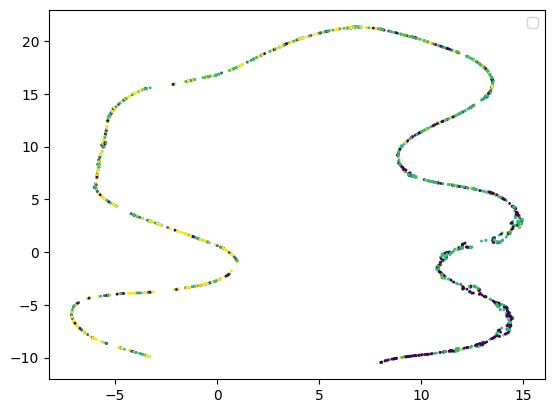

In [42]:
%matplotlib inline
fit = umap.UMAP()
data = df.values[:,:-4]
u = fit.fit_transform(data)
plt.scatter(u[:,0], u[:,1], c=df.values[:,-3].astype(int), s=1)
plt.legend()

In [43]:
umap.plot.interactive?

In [44]:
import umap.plot 
umap.plot.output_notebook()

hover_data = df.iloc[: , -2:]
hover_data.columns = ['day', 'subject']

p = umap.plot.interactive(fit, labels=df.values[:,-3].astype(int),
                          hover_data=hover_data,
                          point_size=4,
                          theme='fire',
                          background='black',
                          interactive_text_search_columns=True)
umap.plot.show(p)

Loading BokehJS ...